In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(11, 9))
plt.rc('font', size=13)
import math

from sklearn.linear_model import LogisticRegression, LinearRegression
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from scipy.stats import chi2_contingency
from scipy.stats import ttest_1samp
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from env import host, user, password
from pydataset import data
from prepare import percentage_stacked_plot
import acquire
import prepare

In [2]:
# acquire telco_df from acquire.py
telco_df = acquire.get_telco_data()

In [3]:
# steps used to prepare data from prepare.py
telco_df = prepare.prep_telco_data(telco_df)

In [4]:
# this function performs split on telco_data, stratify churn. Returns train, validate, and test dfs
train, validate, test = prepare.split_telco_data(telco_df)

# Project Overview

### The goal of this project is to find and identify drivers which cause customer churn at Telco.

- Will attributes of a customers account to include contract type and automatic payment affect churn? 
- Is not having automatic payments an indicator that a customer might possibly churn?
- Can customers who use online security, tech support, and device protection indicate whether they will churn or not?
- Is tenure and monthly/total charges related to when a customer will churn?


## Data Exploration

<function prepare.percentage_stacked_plot(columns_to_plot, title, telco_df)>

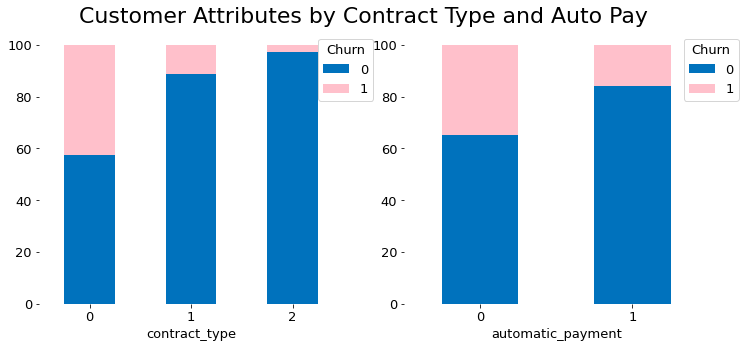

In [5]:
# Attributes of a customer's account
account_columns = ['contract_type', 'automatic_payment']

# stacked plot of these attributes
percentage_stacked_plot(account_columns, 'Customer Attributes by Contract Type and Auto Pay', telco_df)

# contract type 0 is month to month, 1 is one-year, 2 is two-year
# other 0 and 1 is no and yes

### We can conclude by analyzing the above customer account attributes that:

- month-to-month contracts have higher churn rates compared to customers with yearly contracts (1 or 2 year).
- customers who manually pay their bill are more likely to churn.

<function prepare.percentage_stacked_plot(columns_to_plot, title, telco_df)>

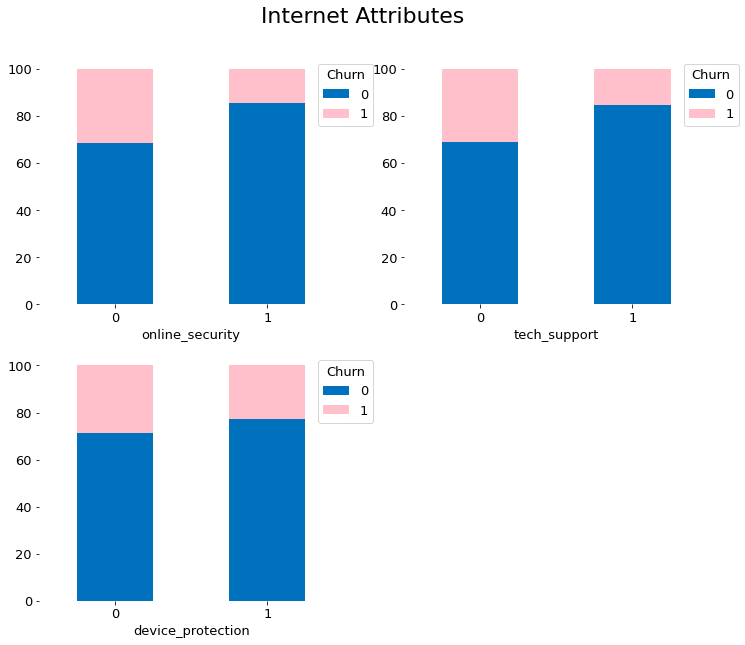

In [6]:
# type of internet service attributes
services_columns = ['online_security', 'tech_support', 'device_protection']

# stacked plot of internet service attributes
percentage_stacked_plot(services_columns, 'Internet Attributes', telco_df)

#0 means no they do not have this feature

### We can conlcude from the above internet service information that:

- Customers without online security churn more than those who have this service.
- Customers without tech support churn more than those who have this service.
- We cannot expect that device protection is significant in predicting churn since they are nearly the same.

### Does online security attribute for internet service types lower risk of churn?
#### Hypothesis testing with chi-squared

- $H_0$ : Online security does not affect churn
- $H_a$ : Online security does affect a customer churning

In [7]:
alpha = 0.05
null_hypothesis = "churn and online_security are independent"
alternative_hypothesis = "there is a relationship between online_security and churn"

# Setup a crosstab of observed churn to online_security
observed = pd.crosstab(train.online_security, train.churn)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
    print('\n',observed.values)
    print('\n',expected)
    print('p_value:',round(p,2))
    #print('\np_value:',(p))
    print(f'chi^2 = {chi2:}')
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")

Reject the null hypothesis that churn and online_security are independent
Sufficient evidence to move forward understanding that there is a relationship between online_security and churn

 [[1902  883]
 [ 989  163]]

 [[2045.06858014  739.93141986]
 [ 845.93141986  306.06858014]]
p_value: 0.0
chi^2 = 127.84579213618441



### Does tech support attribute in internet service types lower risk of churn?
- $H_0$ : Tech support does not affect churn
- $H_a$ : Tech support does affect a customer churning

In [8]:
alpha = 0.05
null_hypothesis = "churn and device protection are independent"
alternative_hypothesis = "there is a relationship between contract type and churn"

# Setup a crosstab of observed churn to tech support
observed = pd.crosstab(train.tech_support, train.churn)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
    print('\n',observed.values)
    print('\n',expected)
    print('\np_value:',(p))
    print(f'chi^2 = {chi2:}')
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")


Reject the null hypothesis that churn and device protection are independent
Sufficient evidence to move forward understanding that there is a relationship between contract type and churn

 [[1929  869]
 [ 962  177]]

 [[2054.61468123  743.38531877]
 [ 836.38531877  302.61468123]]

p_value: 2.376480997030356e-23
chi^2 = 99.12006574346024


### Does device protection attribute for internet service types lower risk of churn?
- $H_0$ : Device protection does not affect churn
- $H_a$ : Device protection does affect a customer churning

In [9]:
alpha = 0.05
null_hypothesis = "churn and device_protection are independent."
alternative_hypothesis = "there is a relationship between online_security and churn."

# Setup a crosstab of observed churn to device protection
observed = pd.crosstab(train.device_protection, train.churn)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
    print('\n',observed.values)
    print('\n',expected)
    print('p_value:',round(p,2))
    #print('\np_value:',(p))
    print(f'chi^2 = {chi2:}')
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")

Reject the null hypothesis that churn and device_protection are independent.
Sufficient evidence to move forward understanding that there is a relationship between online_security and churn.

 [[1830  730]
 [1061  316]]

 [[1879.8475997  680.1524003]
 [1011.1524003  365.8475997]]
p_value: 0.0
chi^2 = 13.940380528973957


<function prepare.percentage_stacked_plot(columns_to_plot, title, telco_df)>

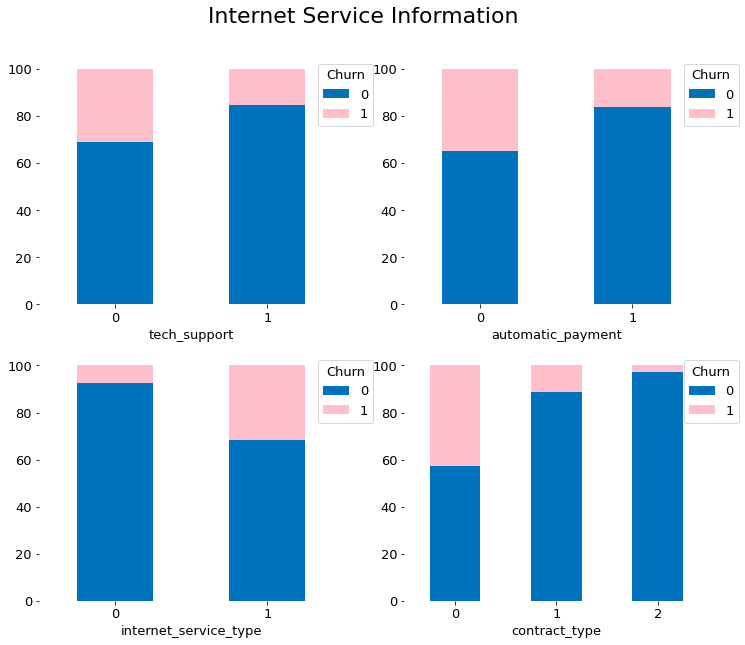

In [10]:
# type of internet service column names
services_columns = ['tech_support', 'automatic_payment','internet_service_type','contract_type']

# stacked plot of internet service columns
percentage_stacked_plot(services_columns, 'Internet Service Information', telco_df)

#0 means no they do not have this feature

#### Hypothesis testing with Correlation

- $H_0$ : There is no linear correlation between monthly charges and whether a customer will churn.
- $H_a$ : There is a linear relationship between monthly charges and whether a customer will churn.

In [11]:
x = telco_df.monthly_charges
y = telco_df.churn
corr, p = stats.pearsonr(x, y)
corr, p

(0.19285821847008663, 6.760843117985555e-60)

Text(0.5, 1.0, 'Monthly charges by churn')

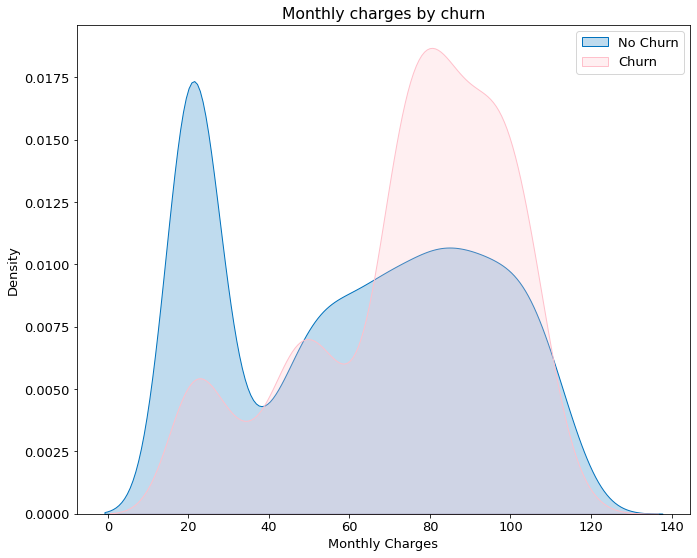

In [12]:
Mth = sns.kdeplot(train.monthly_charges[(train["churn"] == 0) ],
                color="#0072BD", shade = True)
Mth = sns.kdeplot(train.monthly_charges[(train["churn"] == 1) ],
                ax =Mth, color="pink", shade= True)
Mth.legend(["No Churn","Churn"])
Mth.set_ylabel('Density')
Mth.set_xlabel('Monthly Charges')
Mth.set_title('Monthly charges by churn')

Text(0.5, 1.0, 'Total charges by churn')

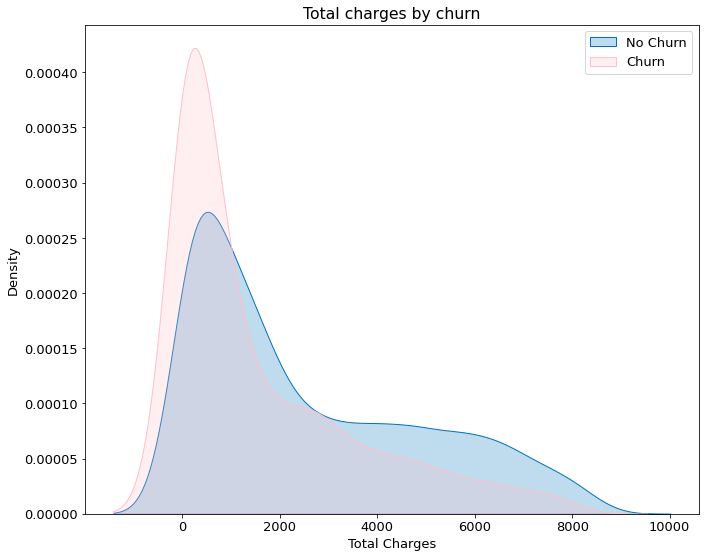

In [13]:
Tot = sns.kdeplot(train.total_charges[(train["churn"] == 0) ],
                color="#0072BD", shade = True)
Tot = sns.kdeplot(train.total_charges[(train["churn"] == 1) ],
                ax =Tot, color="pink", shade= True)
Tot.legend(["No Churn","Churn"],loc='upper right')
Tot.set_ylabel('Density')
Tot.set_xlabel('Total Charges')
Tot.set_title('Total charges by churn')

### We can conclude from the above kdeplots:
- Tenure and total charges are correlated since the longer you are a customer the more you will pay.
- Monthly charges and total charges are correlated since the more of a monthly expense would lead to a higher total expense and affect churn.

## Modeling

In [14]:
target_variable = telco_df['churn'].value_counts()
target_variable

0    5163
1    1869
Name: churn, dtype: int64

In [15]:
# predictor/independent features split into train, test, validate
X_train = train.drop(columns = ['churn'],axis=1)
X_validate = validate.drop(columns = ['churn'],axis=1)
X_test = test.drop(columns = ['churn'],axis=1)

# target variables split into train, test, validate
y_train = train.churn
y_validate = validate.churn
y_test = test.churn

In [16]:
y_train.value_counts(normalize=True)*100

0    73.431547
1    26.568453
Name: churn, dtype: float64

### Majority of customers (73.4%) do not churn - baseline prediction

In [17]:
y_train.value_counts()

0    2891
1    1046
Name: churn, dtype: int64

In [18]:
# Creating data frame of Actual churn
df = pd.DataFrame(y_train)

# Adding baseline as prediction, not churned for every observation
df['baseline'] = 0

# Renaming the columns
df.columns = ['actual','baseline']

In [19]:
pd.crosstab(df.actual, df.baseline)

baseline,0
actual,
0,2891
1,1046


In [20]:
confusion_matrix(df.actual, df.baseline,
                labels = (1, 0))

array([[   0, 1046],
       [   0, 2891]])

In [21]:
# calculate accuracy
# positive will not be churned
# (TP + TN) / (TP + TN + FP + FN)

#predicting not churned and the customer has not churned
TP = 2891

#predicting not churned and the customer has churned
FP = 1046

#predicting the customer has churned and they have churned
TN = 0

#predicting the customer has churned and they have not churned
FN = 0

base_accuracy = (TP + TN) / (TP + TN + FP + FN)

print("The baseline accuracy is",round(base_accuracy * 100,2),"%.")

The baseline accuracy is 73.43 %.


### Logistic Regression Model - Train

In [22]:
#features and weights
X_train = X_train[['online_security','tech_support','device_protection','monthly_charges']]
y_train = train.churn

# Create the LogisticRegression object
logit = LogisticRegression(random_state=123)

# Fit the model
logit.fit(X_train, y_train)

# Evaluate weight of each feature
print('Coefficient: \n', logit.coef_)
print('\nIntercept: \n', logit.intercept_)

# make predicition
y_pred = logit.predict(X_train)

# Estimate probability
y_pred_proba = logit.predict_proba(X_train)

# Evaluate Model
# Compute the Accuracy
print('Accuracy of Logistic Regression classifier on training set: {:.4f}'.format(logit.score(X_train, y_train)))

# Create confusion matrix
print('\nConfusion matrix:\n',confusion_matrix(y_train, y_pred))

# Create classification report
print('\nClassification report:\n',classification_report(y_train, y_pred))

Coefficient: 
 [[-1.1615111  -1.0383524  -0.754254    0.03103148]]

Intercept: 
 [-2.3318484]
Accuracy of Logistic Regression classifier on training set: 0.7557

Confusion matrix:
 [[2651  240]
 [ 722  324]]

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85      2891
           1       0.57      0.31      0.40      1046

    accuracy                           0.76      3937
   macro avg       0.68      0.61      0.62      3937
weighted avg       0.73      0.76      0.73      3937



### Logistic Regression Model - Validate

In [23]:
X_validate = X_validate[['online_security','tech_support','device_protection','monthly_charges']]
y_validate = validate.churn

y_pred = logit.predict(X_validate)

print('\nAccuracy of Logistic Regression classifier on validate set: {:.4f}'
      .format(logit.score(X_validate, y_validate)))
print('\nConfusion matrix:\n',confusion_matrix(y_validate, y_pred))
print('\nClassification report:\n',classification_report(y_validate, y_pred))


Accuracy of Logistic Regression classifier on validate set: 0.7453

Confusion matrix:
 [[1120  119]
 [ 311  138]]

Classification report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.84      1239
           1       0.54      0.31      0.39       449

    accuracy                           0.75      1688
   macro avg       0.66      0.61      0.61      1688
weighted avg       0.72      0.75      0.72      1688



### Random Forest - Train

In [24]:
X_train_ran = X_train[['online_security','tech_support','device_protection','monthly_charges']]
y_train_ran = train.churn

# Create the odjec RF
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

# Fit the model
rf.fit(X_train_ran, y_train_ran)

# Evaluate weight of each feature
print(rf.feature_importances_)

# Make predicitons
y_pred_ran = rf.predict(X_train_ran)

# Estimate probability
y_pred_proba_ran = rf.predict_proba(X_train_ran)

# Compute Accuracy
print('Accuracy of random forest classifier on training set: {:.4f}'.format(rf.score(X_train, y_train)))

# Create confusion matrix
print('\nConfusion matrix:\n',confusion_matrix(y_train_ran, y_pred_ran))
print('\nClassification report:\n',classification_report(y_train_ran, y_pred_ran))

[0.23500208 0.19221508 0.07316693 0.49961592]
Accuracy of random forest classifier on training set: 0.7694

Confusion matrix:
 [[2656  235]
 [ 673  373]]

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.92      0.85      2891
           1       0.61      0.36      0.45      1046

    accuracy                           0.77      3937
   macro avg       0.71      0.64      0.65      3937
weighted avg       0.75      0.77      0.75      3937



### Random Forest - Validate

In [25]:
y_pred_ran = rf.predict(X_validate)

print('Accuracy of random forest classifier on training set: {:.4f}'.format(rf.score(X_validate, y_validate)))

print('\nConfusion matrix:\n',confusion_matrix(y_validate, y_pred_ran))
print('\nClassification report:\n',classification_report(y_validate, y_pred_ran))

Accuracy of random forest classifier on training set: 0.7547

Confusion matrix:
 [[1114  125]
 [ 289  160]]

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84      1239
           1       0.56      0.36      0.44       449

    accuracy                           0.75      1688
   macro avg       0.68      0.63      0.64      1688
weighted avg       0.73      0.75      0.73      1688



### KNN - Train

In [33]:
X_train_knn = X_train[['online_security','tech_support','device_protection','monthly_charges']]
y_train_knn = train.churn

# Create KNN object
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

# Fit the model
knn.fit(X_train_knn, y_train_knn)
KNeighborsClassifier()

# Make Predicitons
y_pred_knn = knn.predict(X_train_knn)

# Estimate Probability
y_pred_proba_knn = knn.predict_proba(X_train_knn)

print('\nThe confusion matrix:\n',confusion_matrix(y_train_knn, y_pred_knn))
print('\nClassification report:\n',classification_report(y_train_knn, y_pred_knn))
print('Accuracy of KNN classifier on training set:',knn.score(X_train_knn, y_train_knn))


The confusion matrix:
 [[2646  245]
 [ 495  551]]

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88      2891
           1       0.69      0.53      0.60      1046

    accuracy                           0.81      3937
   macro avg       0.77      0.72      0.74      3937
weighted avg       0.80      0.81      0.80      3937

Accuracy of KNN classifier on training set: 0.8120396240792481


### KNN - Validate

In [27]:
y_pred_knn = knn.predict(X_validate)

print(confusion_matrix(y_validate, y_pred_knn))
print(classification_report(y_validate, y_pred_knn))

print('\nAccuracy of KNN classifier on validate set:',knn.score(X_validate, y_validate))

[[1105  134]
 [ 306  143]]
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1239
           1       0.52      0.32      0.39       449

    accuracy                           0.74      1688
   macro avg       0.65      0.61      0.61      1688
weighted avg       0.71      0.74      0.72      1688


Accuracy of KNN classifier on validate set: 0.7393364928909952


In [28]:
y_pred_ran = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred_ran))
print(classification_report(y_test, y_pred_ran))

print('\nAccuracy of Random Forest classifier on validate set:',rf.score(X_test, y_test))

ValueError: could not convert string to float: '4716-MRVEN'

## Takeaways

### KNN model outperfomed the others train.